### Imports and setups 
Below are the imports and setups needed for the lab. 

In [2]:
# All imports
from tkinter import Image
import numpy as np
from scipy.signal import convolve2d, correlate2d
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from Functions import *
from mean_shift_example import mean_shift_segm
from norm_cuts_example import norm_cuts_segm
from graphcut_example import graphcut_segm
from scipy.stats import multivariate_normal


def initialize_cluster_centers(image, K, seed):
    np.random.seed(seed)
    h, w, d = image.shape
    flattened_data = image.reshape(h * w, d)

    # Initialize the list of chosen indices
    chosen_indices = []

    # Randomly pick the first center
    first_index = np.random.choice(h * w)
    chosen_indices.append(first_index)

    # Iteratively pick the most different pixels
    for _ in range(1, K):
        remaining_indices = [i for i in range(h * w) if i not in chosen_indices]
        distances = np.linalg.norm(
            flattened_data[remaining_indices] - flattened_data[chosen_indices, None, :],
            axis=2,
        )
        max_distance_index = remaining_indices[np.argmax(np.min(distances, axis=0))]
        chosen_indices.append(max_distance_index)

    # Extract the initial centers
    initial_centers = flattened_data[chosen_indices]
    return initial_centers


def kmeans_segm(image, K, L, seed=42):
    """
    Input Args:
        Image - the RBG input image
        K - the number of clusters
        L - the number of iterations
        seed - the initialization seed
    Output:
        Segmentation - Integer image with cluster indices
        centers - an array with K cluster mean colors
    """
    height, width, dimensions = image.shape
    # Flatten the image
    image_flat = np.reshape(image, (height * width, dimensions))

    # K-means algorithm
    # Initialize the cluster centers randomly
    centers = initialize_cluster_centers(image, K, seed)

    # Iterate L times
    for i in range(L):
        # Assign each pixel to the cluster center for which the distance is minimum
        distances = distance_matrix(image_flat, centers)
        nearest_cluster = np.argmin(distances, axis=1)

        # Update cluster centers
        for j in range(K):
            if np.any(nearest_cluster == j):
                centers[j, :] = np.mean(image_flat[nearest_cluster == j], axis=0)
            else:
                centers[j] = image_flat[np.random.choice(image_flat.shape[0])]

    # Reshape the segmentation and centers
    segmentation = np.reshape(nearest_cluster, (height, width))
    return segmentation, centers


def open_image(name):
    """
    Implement a function that opens an image using Pillow. It should return a numpy array with the image data,  should be a floating point
    """
    image = Image.open(name)
    image = np.array(image).astype(np.float32)
    return image


### Question 1:
Create a function in python that implements the K-means clustering algorithm. 

**Question 1: How did you initialize the clustering process and why do you believe this was a good method of doing it?** <be>

**Answer:**
My initialization was taken from the lectures. The idea is to randomly pick a pixel and use its color, then a pixel that is most different from the first one and the next one that is most different from the first two and so on. This will go on K-times. <br>

This method seems like a good choice as it ensures that the intial centers are as far apart as possible leading to a more effective and possibly more efficient clustering process. 


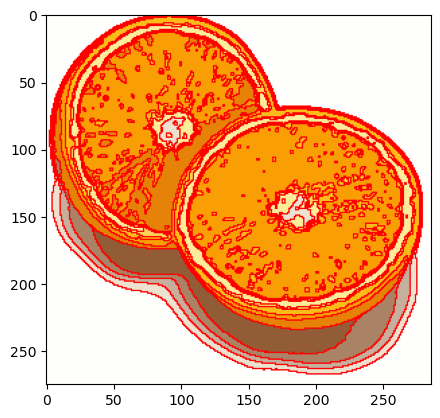

In [3]:
def q1():
    K = 10  # Number of clusters
    L = 40  # Number of iterations
    scale_factor = 0.5  # Downscaling factor
    image_sigma = 1.0  # Image preblurring scale

    image = Image.open("Images-jpg/orange.jpg")
    image = image.resize(
        (int(image.size[0] * scale_factor), int(image.size[1] * scale_factor))
    )

    blur = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(image.filter(blur)).astype(np.float32)

    segmentation, centers = kmeans_segm(I, K, L)
    Inew = mean_segments(I, segmentation)
    if True:
        Inew = overlay_bounds(Inew, segmentation)

    image = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(image)
    plt.show()


q1()

### Question 2: 
How many iterations L do you typically need to reach convergence, that is the point where no additional iterations will affect the end results?

**Answer:**
The number of iterations needed for k-means clustering to reach convergence varies on the number of clusters, size of the image and initialization of the cluster centers. In my case, I found that the number of iterations needed to reach convergence was around 10-15 iterations for 8 clusters. See the image below for an example of the convergence of the algorithm.

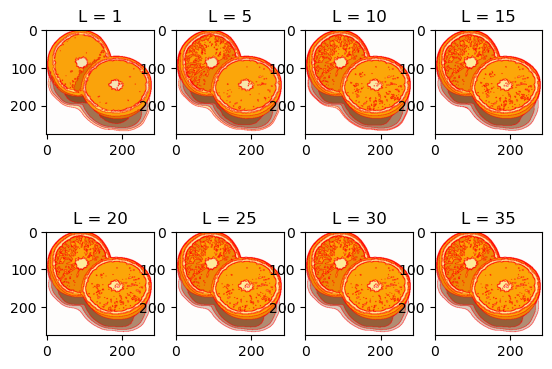

In [4]:
def q2():
    K = 8
    L = [1, 5, 10, 15, 20, 25, 30, 35]
    images = []
    seed = 42
    scale_factor = 0.5
    image_sigma = 1.0

    image = Image.open("Images-jpg/orange.jpg")
    image = image.resize(
        (int(image.size[0] * scale_factor), int(image.size[1] * scale_factor))
    )

    blur = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(image.filter(blur)).astype(np.float32)

    for L_values in L:
        segmentation, centers = kmeans_segm(I, K, L_values, seed)
        Inew = mean_segments(I, segmentation)
        if True:
            Inew = overlay_bounds(Inew, segmentation)
            input_image = Image.fromarray(Inew.astype(np.ubyte))
        images.append(input_image)

    # Plot it all
    fig, axs = plt.subplots(2, 4)
    axs[0, 0].imshow(images[0])
    axs[0, 0].set_title("L = 1")
    axs[0, 1].imshow(images[1])
    axs[0, 1].set_title("L = 5")
    axs[0, 2].imshow(images[2])
    axs[0, 2].set_title("L = 10")
    axs[0, 3].imshow(images[3])
    axs[0, 3].set_title("L = 15")
    axs[1, 0].imshow(images[4])
    axs[1, 0].set_title("L = 20")
    axs[1, 1].imshow(images[5])
    axs[1, 1].set_title("L = 25")
    axs[1, 2].imshow(images[6])
    axs[1, 2].set_title("L = 30")
    axs[1, 3].imshow(images[7])
    axs[1, 3].set_title("L = 35")
    plt.show()


q2()

### Question 3: 
What is the minimum value for K that you can use and still get no superpixel that covers parts from both halves of the orange? Illustrate with a figure. <br>

**Answer:**
From what I found, the minimum value of K that can be used and still get no superpixel that covers parts from both halves of the orange deepnds on the contrats between the halves, shape and size of the halves, size and resolution of the image and the blur of the image.  <br>

In my case, I found that the minimum value of K that can be used and still get no superpixel that covers parts from both halves of the orange is 8. See the image below for an example of the clustering with 8 clusters.

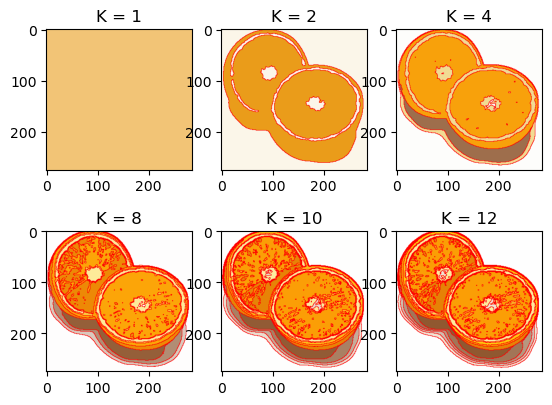

In [5]:
def q3():
    K = [1,2,4,8,10,12]  # number of clusters used
    L = 30  # number of iterations
    seed = 14  # seed used for random initialization
    scale_factor = 0.5  # image downscale factor
    image_sigma = 1.0  # image preblurring scale
    image_list = []

    img = Image.open("Images-jpg/orange.jpg")
    img = img.resize((int(img.size[0] * scale_factor), int(img.size[1] * scale_factor)))

    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)

    for K_values in K:
        segmentation, centers = kmeans_segm(I, K_values, L, seed)
        Inew = mean_segments(I, segmentation)
        if True:
            Inew = overlay_bounds(Inew, segmentation)
            input_image = Image.fromarray(Inew.astype(np.ubyte))
        image_list.append(input_image)

    # Plot it all
    fig, axs = plt.subplots(2, 3)
    axs[0, 0].imshow(image_list[0])
    axs[0, 0].set_title("K = 1")
    axs[0, 1].imshow(image_list[1])
    axs[0, 1].set_title("K = 2")
    axs[0, 2].imshow(image_list[2])
    axs[0, 2].set_title("K = 4")
    axs[1, 0].imshow(image_list[3])
    axs[1, 0].set_title("K = 8")
    axs[1, 1].imshow(image_list[4])
    axs[1, 1].set_title("K = 10")
    axs[1, 2].imshow(image_list[5])
    axs[1, 2].set_title("K = 12")
    plt.show()
    


q3()

### Question 4: 
What needs to be changed in the parameters to get suitable superpixels for the tiger images as well?


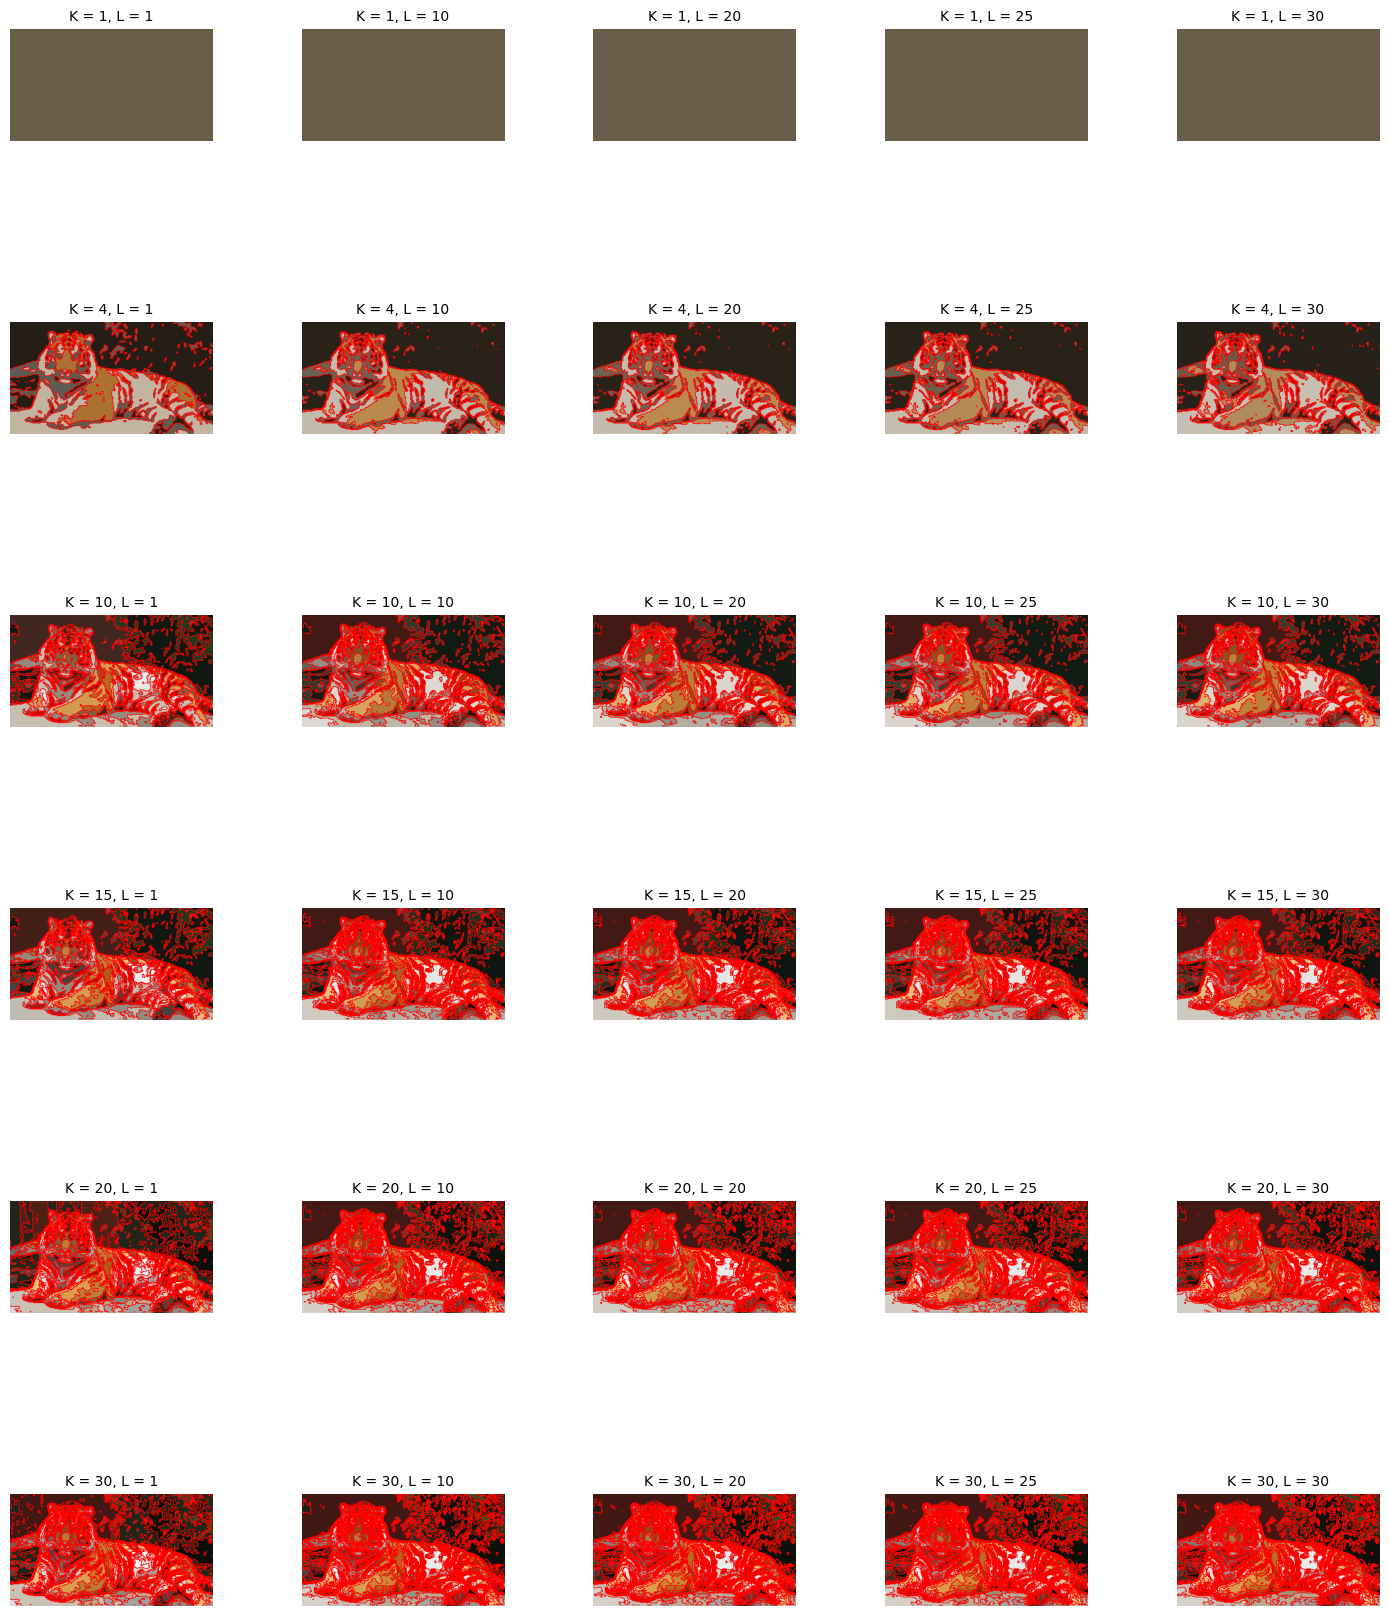

In [6]:
def q4():
    K = [1, 4, 10, 15, 20, 30]  # number of clusters used
    L = [1, 10, 20, 25, 30]  # number of iterations
    seed = 14  # seed used for random initialization
    scale_factor = 0.5  # image downscale factor
    image_sigma = 1.0  # image preblurring scale
    image_list = []

    img = Image.open("Images-jpg/tiger1.jpg")
    img = img.resize((int(img.size[0] * scale_factor), int(img.size[1] * scale_factor)))

    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)

    for K_values in K:
        for L_values in L:
            segmentation, centers = kmeans_segm(I, K_values, L_values, seed)
            Inew = mean_segments(I, segmentation)
            if True:
                Inew = overlay_bounds(Inew, segmentation)
                input_image = Image.fromarray(Inew.astype(np.ubyte))
            image_list.append(input_image)

    # Improved plot layout
    fig, axs = plt.subplots(
        6, 5, figsize=(15, 18)
    )  # Adjusted figure size for better spacing
    fig.tight_layout(pad=3.0)  # Increased padding between plots

    # Populating the subplots with images and titles
    for i in range(6):
        for j in range(5):
            axs[i, j].imshow(image_list[i * 5 + j])
            axs[i, j].set_title(
                "K = {}, L = {}".format(K[i], L[j]), fontsize=10
            )  # Smaller font size for titles
            axs[i, j].axis("off")  # Remove axis for cleaner look
    # Show the plot
    plt.show()

q4()

## Question 5 
How do the results change depending on the bandwidths? What settings did you prefer for the different images? Illustrate with an example image with the parameter that you think are suitable for that image.

**Answer:**
The spatial bandwidth controls the influence of spatial proximity on the clustering process. If this is set to be large, the cluster segments would be larger as a wider area would be considered around each pixel. Often results in a merging of nearby regions which have similar colors.

The color bandwidth is used to control how the variation in color influences the segmentation. If this is set to be large, there can be more variation in color present within the segment. When images have more color variation, a smaller color bandwidth is preferred to preserve details while applying the segmentation. When the color bandwidth is set to be large, the color variation within the segment is more and the details are lost.

Find colour channels with K-means...
Search for high density points...
Assign high density points to pixels...
Find colour channels with K-means...
Search for high density points...
Assign high density points to pixels...
Find colour channels with K-means...
Search for high density points...
Assign high density points to pixels...
Find colour channels with K-means...
Search for high density points...
Assign high density points to pixels...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


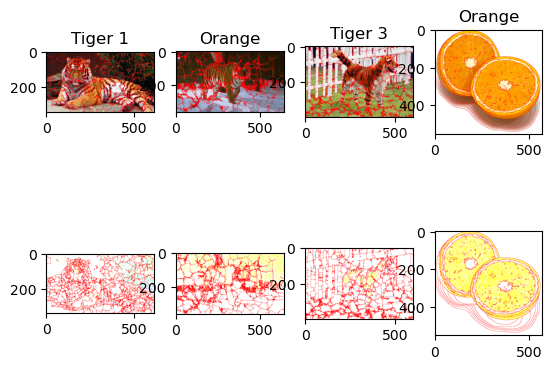

In [7]:
def q5():
    scale_factor = 1

    # Load the image
    tiger_img = Image.open("Images-jpg/tiger1.jpg")
    orange_img = Image.open("Images-jpg/orange.jpg")
    tiger2_img = Image.open("Images-jpg/tiger2.jpg")
    tiger3_img = Image.open("Images-jpg/tiger3.jpg")

    tiger_img = tiger_img.resize(
        (int(tiger_img.size[0] * scale_factor), int(tiger_img.size[1] * scale_factor))
    )
    orange_img = orange_img.resize(
        (
            int(orange_img.size[0] * scale_factor),
            int(orange_img.size[1] * scale_factor),
        )
    )
    tiger2_img = tiger2_img.resize(
        (
            int(tiger2_img.size[0] * scale_factor),
            int(tiger2_img.size[1] * scale_factor),
        )
    )
    tiger3_img = tiger3_img.resize(
        (
            int(tiger3_img.size[0] * scale_factor),
            int(tiger3_img.size[1] * scale_factor),
        )
    )

    # Convert the images into numpy arrays
    tiger = np.asarray(tiger_img).astype(np.float32)
    orange = np.asarray(orange_img).astype(np.float32)
    tiger2 = np.asarray(tiger2_img).astype(np.float32)
    tiger3 = np.asarray(tiger3_img).astype(np.float32)

    # Spatial and color bandwiths
    spatial_bandwidth_orange = 2
    color_bandwidth_orange = 40

    # Tiger 1
    spatial_bandwidth_tiger = 5
    color_bandwidth_tiger = 40
    # Tiger 2
    spatial_bandwidth_tiger2 = 10
    color_bandwidth_tiger2 = 40
    # Tiger 3
    spatial_bandwidth_tiger3 = 10
    color_bandwidth_tiger3 = 40

    # Perform mean shift Segmentation
    tiger_segmentation = mean_shift_segm(
        tiger, spatial_bandwidth_tiger, color_bandwidth_tiger, 40
    )

    orange_segmentation = mean_shift_segm(
        orange, spatial_bandwidth_orange, color_bandwidth_orange, 40
    )

    tiger2_segmentation = mean_shift_segm(
        tiger2, spatial_bandwidth_tiger2, color_bandwidth_tiger2, 40
    )

    tiger3_segmentation = mean_shift_segm(
        tiger3, spatial_bandwidth_tiger3, color_bandwidth_tiger3, 40
    )

    # Dipslay the segmented images
    tiger_new = overlay_bounds(tiger, tiger_segmentation)
    tiger_display = Image.fromarray(tiger_new.astype(np.ubyte))

    orange_new = overlay_bounds(orange, orange_segmentation)
    orange_display = Image.fromarray(orange_new.astype(np.ubyte))

    tiger2_new = overlay_bounds(tiger2, tiger2_segmentation)
    tiger2_display = Image.fromarray(tiger2_new.astype(np.ubyte))

    tiger3_new = overlay_bounds(tiger3, tiger3_segmentation)
    tiger3_display = Image.fromarray(tiger3_new.astype(np.ubyte))

    # plot it all
    fig, axs = plt.subplots(2, 4)
    axs[0, 0].set_title("Tiger 1")
    axs[0, 1].set_title("Tiger 2")
    axs[0, 2].set_title("Tiger 3")
    axs[0, 3].set_title("Orange")
    axs[0, 0].imshow(tiger_display)
    axs[0, 1].imshow(tiger2_display)
    axs[0, 2].imshow(tiger3_display)
    axs[0, 3].imshow(orange_display)
    axs[1, 0].imshow(tiger_new)
    axs[1, 1].imshow(tiger2_new)
    axs[1, 2].imshow(tiger3_new)
    axs[1, 3].imshow(orange_new)

    axs[0, 1].set_title("Orange")

    plt.show()


q5()

## Question 6
What kind of similarities and differences do you see between K-means and mean-shift segmentations?

**Answer:**
Both of them are clustering algorithms used in image segmentation but they differ in their approaches and assumptions. Below is a comparison of their similarities and differences.

**Similarities:**
- Both are clustering algorithms used in image segmentation
- Both are iterative algorithms that update their parameters (cluster centers in K-means and search window locations in mean-shift) to optimize a certain criterion.
- Seems to be robust to noise

**Difference:**
- **Clusters:** Tehires the number of clusters to be a specified parameter while mean-shift does not require the number of clusters to be specified, it relies on the a bandwidth parameter.
- **Cluster view** In K-means, the clusters are circular while in mean-shift, the clusters change shape based on the data.
- **Computation** K-means is quick and efficient while mean-shift is slower and computationally expensive.
- **Initialization** K-means requires the number of clusters to be specified and the initial cluster centers to be specified while mean-shift does not require the number of clusters to be specified and the initial cluster centers are chosen randomly.

There are many more but I'll write them down as I come across them.


## Question 7
Does the ideal parameter setting vary depending on the images? If you look at the images, can you see a reason why the ideal settings might differ? Illustrate with an example image using the parameters you prefer for that image.

**Answer:**
I would assume that the ideal parameters differs from image to image. This is because the ideal parameters depend on the size of the image, the resolution of the image, the contrast of the image, the color variation in the image, the shape of the image and the blur of the image. That being said these are how the different parameters affect the segmentation process.

- **Color Bandwidth:** Used to define threshold for color similarit. If value was larger, a wider range of colors would be considered similar and the segments would be larger. If value was smaller, a smaller range of colors would be considered similar and the segments would be smaller.

- **Radius:** Maximum distance within two pixels are considered neighbours. If value was larger, a wider range of pixels would be considered neighbours and the segments would be larger. If value was smaller, a smaller range of pixels would be considered neighbours and the segments would be smaller.

- **Ncuts_thresh:** Used to define minimum cost considered before cutting into segments. A segment is not further divided if the normalized cost is below this threshold. If value was larger, a wider range of pixels would be considered similar and the segments would be larger. If value was smaller, a smaller range of pixels would be considered similar and the segments would be smaller.

- **Min_size:** Used to define minimum size of a segment. If value was larger, the segments would be larger. If value was smaller, the segments would be smaller.

- **Scale_factor:** Used to scale dow nimage before processing. Reduces the image size and thereby decrease processing time

- **Image sigma:** Used to define the standard deviation of the Gaussian smoothing filter applied to the image before processing. If value was larger, the image would be more blurred and the segments would be larger. If value was smaller, the image would be less blurred and the segments would be smaller.

Compute affinity matrix...
Solve eigenvalue problems to find partitions...
Cutting ncut=0.001 sizes=(6898,6192) ROOT
Cutting ncut=0.008 sizes=(4481,2417) ROOT-A
Cutting ncut=0.001 sizes=(869,3612) ROOT-A-A
Cutting ncut=0.003 sizes=(582,287) ROOT-A-A-A
Cutting ncut=0.021 sizes=(432,150) ROOT-A-A-A-A
Cutting ncut=0.013 sizes=(209,78) ROOT-A-A-A-B
Cutting ncut=0.027 sizes=(1823,1789) ROOT-A-A-B
Cutting ncut=0.032 sizes=(101,1722) ROOT-A-A-B-A
Cutting ncut=0.045 sizes=(860,929) ROOT-A-A-B-B
Cutting ncut=0.057 sizes=(332,528) ROOT-A-A-B-B-A
Cutting ncut=0.081 sizes=(134,198) ROOT-A-A-B-B-A-A
Cutting ncut=0.092 sizes=(299,229) ROOT-A-A-B-B-A-B
Cutting ncut=0.119 sizes=(117,182) ROOT-A-A-B-B-A-B-A
Cutting ncut=0.097 sizes=(103,126) ROOT-A-A-B-B-A-B-B
Cutting ncut=0.053 sizes=(511,418) ROOT-A-A-B-B-B
Cutting ncut=0.060 sizes=(286,225) ROOT-A-A-B-B-B-A
Cutting ncut=0.092 sizes=(127,159) ROOT-A-A-B-B-B-A-A
Cutting ncut=0.181 sizes=(102,123) ROOT-A-A-B-B-B-A-B
Cutting ncut=0.043 sizes=(268,150) R

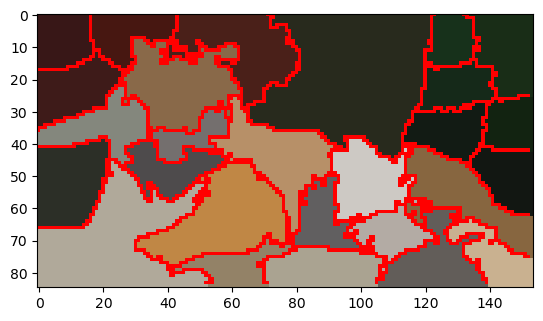

In [8]:
def Q7():
    colour_bandwidth = 20.0  # color bandwidth
    radius = 3  # maximum neighbourhood distance
    ncuts_thresh = 0.10  # cutting threshold
    min_area = 200  # minimum area of segment
    max_depth = 15  # maximum splitting depth
    scale_factor = 0.25  # image downscale factor
    image_sigma = 0.5  # image preblurring scale

    # Load images
    tiger_img = Image.open("Images-jpg/tiger1.jpg")
    tiger_img = tiger_img.resize(
        (int(tiger_img.size[0] * scale_factor), int(tiger_img.size[1] * scale_factor))
    )
    blur = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(tiger_img.filter(blur)).astype(np.float32)

    # Perform Normalized Cuts
    segmentation = norm_cuts_segm(
        I, colour_bandwidth, radius, ncuts_thresh, min_area, max_depth
    )
    Inew = mean_segments(I, segmentation)
    if True:
        Inew = overlay_bounds(Inew, segmentation)

    # Display results
    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.show()


Q7()

## Question 8
Which parameter(s) was most effective for reducing the subdivision and still result in a satisfactory segmentation?

**Answer:**
To reduce the subdivision keeping the same segmentatino, we can modify
- Ncuts_thresh
- Min_size
- Max_depth


## Question 9
Why does Normalized Cut prefer cuts of approximately equal size? Does this happen in practice?

**Answer:**
Normalized cut prefers aims to find a balance between segment sizes, consdering not only the cut itself but aslo the total connections within each segment. Does this by normalizing the cut by the total edge connections in each segment. This approach discourages cuts that isolate small groups of highly connected nodes or pixels as it would result in a high normalized cut value.



## Question 10
Did you manage to increase radius and how did it affect the results?

**Answer:**
It seems that it increased the segments or at least the colors of the segments looks more 'better'. I'm not sure if this is the right way to describe it but it seems like the colors of the segments are more 'pure' and less 'mixed'.

Compute affinity matrix...
Solve eigenvalue problems to find partitions...
Cutting ncut=0.001 sizes=(8894,4196) ROOT
Cutting ncut=0.001 sizes=(2593,6301) ROOT-A
Cutting ncut=0.003 sizes=(1716,877) ROOT-A-A
Cutting ncut=0.002 sizes=(1027,689) ROOT-A-A-A
Cutting ncut=0.003 sizes=(297,730) ROOT-A-A-A-A
Cutting ncut=0.021 sizes=(127,170) ROOT-A-A-A-A-A
Cutting ncut=0.025 sizes=(421,309) ROOT-A-A-A-A-B
Cutting ncut=0.032 sizes=(238,183) ROOT-A-A-A-A-B-A
Cutting ncut=0.036 sizes=(304,5) ROOT-A-A-A-A-B-B
Cutting ncut=0.015 sizes=(60,629) ROOT-A-A-A-B
Cutting ncut=0.005 sizes=(531,346) ROOT-A-A-B
Cutting ncut=0.017 sizes=(353,178) ROOT-A-A-B-A
Cutting ncut=0.002 sizes=(296,50) ROOT-A-A-B-B
Cutting ncut=0.001 sizes=(5603,698) ROOT-A-B
Cutting ncut=0.000 sizes=(4841,762) ROOT-A-B-A
Cutting ncut=0.000 sizes=(3869,972) ROOT-A-B-A-A
Cutting ncut=0.000 sizes=(3842,27) ROOT-A-B-A-A-A
Cutting ncut=0.000 sizes=(614,358) ROOT-A-B-A-A-B
Cutting ncut=0.001 sizes=(66,548) ROOT-A-B-A-A-B-A
Cutting ncut=0.00

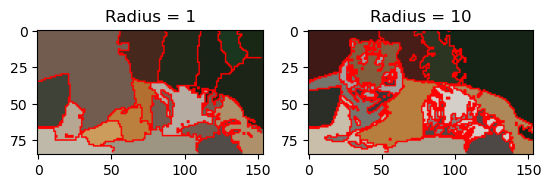

In [9]:
def Qten():
  colour_bandwidth = 20.0  # color bandwidth
  radius_1 = 1  
  radius_2 = 10

  ncuts_thresh = 0.10  # cutting threshold
  min_area = 200  # minimum area of segment
  max_depth = 12  # maximum splitting depth
  scale_factor = 0.25  # image downscale factor
  image_sigma = 0.5  # image preblurring scale

  # Load images
  tiger_img = Image.open("Images-jpg/tiger1.jpg")
  tiger_img = tiger_img.resize(
      (int(tiger_img.size[0] * scale_factor), int(tiger_img.size[1] * scale_factor))
  )
  blur = ImageFilter.GaussianBlur(image_sigma)
  I = np.asarray(tiger_img.filter(blur)).astype(np.float32)

  # Perform Normalized Cuts, one for each radius
  segmentation_1 = norm_cuts_segm(I, colour_bandwidth, radius_1, ncuts_thresh, min_area, max_depth)
  segmentation_2 = norm_cuts_segm(I, colour_bandwidth, radius_2, ncuts_thresh, min_area, max_depth)

  # Display results
  Inew_1 = mean_segments(I, segmentation_1)
  Inew_2 = mean_segments(I, segmentation_2)
  if True:
      Inew_1 = overlay_bounds(Inew_1, segmentation_1)
      Inew_2 = overlay_bounds(Inew_2, segmentation_2)
    
  # Display results
  img_1 = Image.fromarray(Inew_1.astype(np.ubyte))
  img_2 = Image.fromarray(Inew_2.astype(np.ubyte))

  # plot it all
  fig, axs = plt.subplots(1, 2)
  axs[0].set_title("Radius = 1")
  axs[1].set_title("Radius = 10")
  axs[0].imshow(img_1)
  axs[1].imshow(img_2)
  plt.show()

Qten()



## Question 11 
Does the ideal choice of alpha and sigma vary a lot between different images? Illustrate with an example image with the parameters you prefer.

**Answer:**
Alpha - The maximum cost of an edge: When increasing alpha, we increase the maximum cost of an edge making it more difficult to cut across similar pixels or smooth surfaces as they will have higher costs. Higher alpha will preserve edges during segmentation-

Sigma - How much the cost decays for decreasing similarity between neighbouring pixels. Used in edge weight calculation.  

If we lower both paramters, the cuts will be more sensitive and the accuacy of the segmentation will decrease as we are ok with cutting similar pixels with high edge values or costs. 


Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...


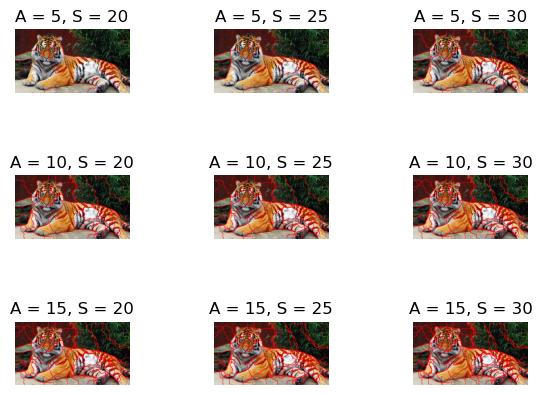

In [10]:
def qeleven():
  scale_factor = 0.5  # image downscale factor
  area = [
      80,
      110,
      570,
      300,
  ]  # image region to train foreground with [ minx, miny, maxx, maxy ]
  K = 10  # number of mixture components
  
  alpha = [5,10,15]  # maximum edge cost
  sigma = [20,25,30]  # edge cost decay factor

  img = Image.open("Images-jpg/tiger1.jpg")
  img = img.resize((int(img.size[0] * scale_factor), int(img.size[1] * scale_factor)))

  area = [int(i * scale_factor) for i in area]
  I = np.asarray(img).astype(np.float32)

  # Create a figure with subplots athat contains alphas and sigmas
  fig, axs = plt.subplots(3, 3)
  fig.tight_layout(pad=3.0)  # Increased padding between plots

  for i in range(3):
      for j in range(3):
          # Perform Graph Cut Segmentation
          segm, prior = graphcut_segm(I, area, K, alpha[i], sigma[j])
          Inew = mean_segments(I, segm)
          if True:
              Inew = overlay_bounds(img, segm)

          # Display results
          img = Image.fromarray(Inew.astype(np.ubyte))
          axs[i, j].imshow(img)
          axs[i, j].set_title("A = {}, S = {}".format(alpha[i], sigma[j]))
          axs[i, j].axis("off")
  plt.show()

qeleven()

## Question 12
How much can you lower K untill the results get considerably worse?

C:\Users\rakin\AppData\Local\Temp\ipykernel_11460\184168301.py:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=3.0)  # Increased padding between plots


Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...
number of iterations = 100
Find Gaussian mixture models...
Find minimum cut...


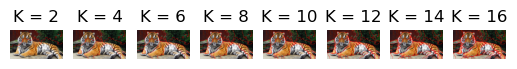

In [11]:
def qtwelve():
  scale_factor = 0.5  # image downscale factor
  area = [
      80,
      110,
      570,
      300,
  ]  # image region to train foreground with [ minx, miny, maxx, maxy ]
  K = [2,4,6,8,10,12,14,16]  # number of mixture components

  alpha = 8
  sigma = 30

  img = Image.open("Images-jpg/tiger1.jpg")
  img = img.resize((int(img.size[0] * scale_factor), int(img.size[1] * scale_factor)))

  area = [int(i * scale_factor) for i in area]
  I = np.asarray(img).astype(np.float32)

  # Create a figure with 1 row and 8 columns for k values
  fig, axs = plt.subplots(1, 8)
  fig.tight_layout(pad=3.0)  # Increased padding between plots

  for i in range(8):
      # Perform Graph Cut Segmentation
      segm, prior = graphcut_segm(I, area, K[i], alpha, sigma)
      Inew = mean_segments(I, segm)
      if True:
          Inew = overlay_bounds(img, segm)

      # Display results
      img = Image.fromarray(Inew.astype(np.ubyte))
      axs[i].imshow(img)
      axs[i].set_title("K = {}".format(K[i]))
      axs[i].axis("off")
  plt.show()

qtwelve()


## Question 13: 
Unlike the earlier method Graph Cut segmentation relies on some input from a user for defining a rectangle. Is the benefit you get of this worth the effort? Motivate! 

**Answer**
Depends on the picture which the algorithm is applied to. If the picture is simple and the object is easily distinguishable from the background, then the rectangle can be easily drawn and the algorithm can be applied. However, if the picture is complex and the object is not easily distinguishable from the background, then the rectangle can be difficult to draw and the algorithm may not be able to be applied.

## Question 14:
What are the	key	differences	and	similarities	between	the	segmentation methods	(K-means,	Mean-shift,	Normalized	Cut	and	energy-based segmentation	with Graph	Cuts)	in	this	lab?	Think	carefully!!

**Answer:**

**Similarities:**
- All of the methods use clustering to group points. Mainly based on similarity of color and in some cases, spatial proximity.
- Mean-shift and Graph cut both use the Gaussian distribution to model the data. 
- Both 

**Differences:**
- Energy based segmentation using graph cuts requires prior information about the expected ratio of background to foreground in order to produce more accurate results. Normalized cut does not require this information.
- Mean-shift and the graph based methods look at the spatial information into account while K-means, in this code, looks only at the color information.

<br>
K mean does not care to what is in the image or if it should be a part of the background ot not, it simply creates clusters based on the color similarity and spatial proximity of the pixels then assigns each pixel to the cluster that it is most similar to. <br>

Mean shift is similar to K mean in that it also creates clusters based on the color similarity and spatial proximity of the pixels but it does not require the number of clusters to be specified. Instead, it uses a bandwidth parameter to define the radius of the search window. The search window is centered around a pixel and the mean of the pixels within the search window is calculated. The center of the search window is then shifted to the mean and the process is repeated until convergence. <br>

Normalized cut is different from K mean and mean shift in that it does not use clustering to segment the image. Instead, it uses graph theory to segment the image. It first creates a graph where each pixel is a node and the edges are the similarity between the pixels. It then uses the graph to find the minimum cut which is the cut that minimizes the cost of the cut. The cost of the cut is the sum of the weights of the edges that are cut. The cut is done by removing the edges with the highest weights. The process is repeated until the cost of the cut is below a certain threshold. <br>

Energy-based segmentation using graph cuts is different from the other methods in that it requires prior information about the expected ratio of background to foreground. It then uses this information to create a graph where each pixel is a node and the edges are the similarity between the pixels. It then uses the graph to find the minimum cut which is the cut that minimizes the cost of the cut. The cost of the cut is the sum of the weights of the edges that are cut. The cut is done by removing the edges with the highest weights. The process is repeated until the cost of the cut is below a certain threshold. <br>